In [23]:
import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.
from flax import nnx  # The Flax NNX API.
from functools import partial
import jax.numpy as jnp  # JAX NumPy
import jax
import optax
from linearRNN import forward_h
from linearRNN import forward
from linearRNN import init_lru_parameters
from linearRNN import binary_operator_diag
from linearRNN import compute_lr_sigma
from linearRNN import LRU
import numpy as np
from flax import linen as nn

In [ ]:
pool = 0  # pooling layer after MLP is taking the average over the numbers
transformation = 0  # transformation of the data from decimals between 0 and 255 to binary 8 bit numbers
leave_data = 1  # download csv data of the results
multi_opt = 0  # change the learning rate and the variance of the initialized weights per layer by using the multi-optimizer
hidden_neuron = 64  # no details in the 2023 paper => 2024 paper fixed to 512
encoded_size = 256
hidden_size = 128
learning_rate = 0.004
momentum = 0.9
train_steps = 3000
eval_every = 50
batch_size = 50
r_min = 0.9
r_max = 0.999
max_phase = 6.28
depth = 1
lr_factor=0.25
method_name = "LRUMLP"
dataset_name = "MNIST"

In [25]:
def vec_bin_array(arr, m):
    # https://stackoverflow.com/questions/22227595/convert-integer-to-binary-array-with-suitable-padding
    """
    Arguments:
    arr: Numpy array of positive integers
    m: Number of bits of each integer to retain

    Returns a copy of arr with every element replaced with a bit vector.
    Bits encoded as int8's.
    """
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(m))
    strs = to_str_func(arr)
    ret = np.zeros(list(arr.shape) + [m], dtype=np.int8)
    for bit_ix in range(0, m):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == "1")
        ret[..., bit_ix] = fetch_bit_func(strs).astype("int8")

    return ret

In [26]:
# Import data

if dataset_name == "MNIST":
    dataset = tf.keras.datasets.mnist.load_data()
    train = dataset[0]
    test = dataset[1]

    train_x_seq = train[0].shape[0]
    train_x_len = int(jnp.prod(jnp.array(train[0].shape[1:])))
    train_x_size = 1
    test_x_seq = test[0].shape[0]
    test_x_len = int(jnp.prod(jnp.array(test[0].shape[1:])))
    test_x_size = 1
    if transformation:  # transform the information of the pixel to 8-bit binary numbers
        train_x = train[0].reshape((train_x_seq, train_x_len, train_x_size))
        train_x = vec_bin_array(train_x, 8)
        train_y = train[1].reshape(train_x_seq)
        train_y_class = len(jnp.unique(train_y))
        test_x = test[0].reshape((test_x_seq, test_x_len, test_x_size))
        test_x = vec_bin_array(test_x, 8)
        test_y = test[1].reshape(test_x_seq)
    else:
        train_x = train[0].reshape((train_x_seq, train_x_len, train_x_size)) / 255
        train_y = train[1].reshape(train_x_seq)
        train_y_class = len(jnp.unique(train_y))
        test_x = test[0].reshape((test_x_seq, test_x_len, test_x_size)) / 255
        test_y = test[1].reshape(test_x_seq)

if dataset_name == "CIFAR10":
    dataset = tf.keras.datasets.cifar10.load_data()
    train = dataset[0]
    test = dataset[1]

    train_x_seq = train[0].shape[0]
    train_x_len = int(jnp.prod(jnp.array(train[0].shape[1:-1])))
    train_x_size = int(jnp.prod(jnp.array(train[0].shape[-1])))

    test_x_seq = test[0].shape[0]
    test_x_len = int(jnp.prod(jnp.array(test[0].shape[1:-1])))
    test_x_size = int(jnp.prod(jnp.array(train[0].shape[-1])))

    if (
        transformation
    ):  # transform the information of the pixel to 3*8-bit binary numbers
        train_x = train[0].reshape((train_x_seq, train_x_len, train_x_size))
        train_x = vec_bin_array(train_x, 8)
        train_y = train[1].reshape(train_x_seq)
        train_y_class = len(jnp.unique(train_y))
        test_x = test[0].reshape((test_x_seq, test_x_len, test_x_size))
        test_x = vec_bin_array(test_x, 8)
        test_y = test[1].reshape(test_x_seq)
    else:
        train_x = train[0].reshape((train_x_seq, train_x_len, train_x_size)) / 255
        train_y = train[1].reshape(train_x_seq)
        train_y_class = len(jnp.unique(train_y))
        test_x = test[0].reshape((test_x_seq, test_x_len, test_x_size)) / 255
        test_y = test[1].reshape(test_x_seq)


print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(60000, 784, 1)
(60000,)
(10000, 784, 1)
(10000,)


In [27]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (jnp.real(train_x), jnp.array(train_y, dtype=int))
)
test_ds = tf.data.Dataset.from_tensor_slices(
    (jnp.real(test_x), jnp.array(test_y, dtype=int))
)

train_ds = train_ds.repeat().shuffle(100)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the next sample to improve latency.
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
from flax import nnx
import optax
from flax.nnx.nn.recurrent import LSTMCell, GRUCell
import copy
import random


class MLP(nnx.Module):
    # DON'T FORGET TO CHANGE THE MODEL NAME BEFORE RUNNING
    # According to the scheme of the paper (Figure 1), input_size=M, encoded_size=H,layer_dim=number of neurons in MLP, out_dim=number of classes
    def __init__(
        self,
        token_size,
        token_len,
        encoded_dim,
        hidden_dim,
        layer_dim,
        out_dim,
        rngs: nnx.Rngs,
    ):

        # linear encoder
        # lrE,sigmaE=compute_lr_sigma("input",token_size,encoded_dim,0,1)
        # self.lin_encoder = nnx.Linear(in_features=token_size, out_features=encoded_dim,rngs=rngs,kernel_init=sigmaE*jax.random.normal)
        self.lin_encoder = nnx.Linear(
            in_features=token_size, out_features=encoded_dim, rngs=rngs
        )

        # LRU+MLP block
        # lrL1, sigmaL1= compute_lr_sigma("input",encoded_dim,layer_dim,0,1)
        # lrL2, sigmaL2=compute_lr_sigma("output",0,layer_dim,encoded_dim,1)
        # self.linear1 = nnx.Linear(in_features=encoded_dim, out_features=layer_dim, rngs=rngs,kernel_init=sigmaL1*jax.random.normal))
        # self.linear2 = nnx.Linear(in_features=layer_dim//2,out_features=encoded_dim,rngs=rngs,kernel_init=sigmaL2*jax.random.normal))
        self.rnn = LRU(
            in_features=encoded_dim,
            hidden_features=hidden_dim,
            r_min=r_min,
            r_max=r_max,
            max_phase=max_phase,
        )
        self.linear1 = nnx.Linear(
            in_features=encoded_dim, out_features=layer_dim, rngs=rngs
        )
        self.linear2 = nnx.Linear(
            in_features=layer_dim // 2, out_features=encoded_dim, rngs=rngs
        )
        self.batchnorm = nnx.BatchNorm(
            num_features=encoded_dim, rngs=rngs, use_running_average=True
        )

        # Linear layers
        if pool:  # If pooling layer takes the average over the token sequence length
            self.linear3 = lambda x: jnp.mean(x, axis=1)
        else:  # learn the parameters of the linear transformation
            self.linear3 = nnx.Linear(in_features=token_len, out_features=1, rngs=rngs)
        self.linear4 = nnx.Linear(
            in_features=encoded_dim, out_features=out_dim, rngs=rngs
        )
        self.out_dim = out_dim
        self.token_len = token_len
        self.dropout = nnx.Dropout(0.1, rngs=rngs)

    @nnx.vmap(in_axes=(None, 0))
    def __call__(self, x):
        x = self.lin_encoder(x)
        # x=x@self.lin_encoder
        y = x.copy()

        # LRU+MLP block
        for i in range(depth):
            x = self.rnn(x)
            x = self.linear1(x)
            x = nnx.glu(x, axis=-1)
            x = self.linear2(x)
            x = self.dropout(x)
            x += y  # Skip connection -> p.21 adding for each block
            x = self.batchnorm(x)  # batch normalization

        # x = x.T@self.weight #+ self.bias #project from L*H to H*1
        # x = self.weight2@x #+ self.bias2#project from H*1 to out_dim
        x = self.linear3(x.T)
        x = self.linear4(x.T)
        return x.reshape(self.out_dim)
    


model = MLP(
    train_x_size,
    train_x_len,
    encoded_size,
    hidden_size,
    hidden_neuron,
    train_y_class,
    rngs=nnx.Rngs(0),
)  # eager initialization

#nnx.display(model)

In [ ]:
params=jax.tree.map(jnp.shape, nnx.state(model))

def map_nested_fn(fn):

  '''Recursively apply `fn` to key-value pairs of a nested dict.'''

  def map_fn(nested_dict):

    return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v))

            for k, v in nested_dict.items()}

  return map_fn

label_fn = map_nested_fn(lambda k, _: k)

gradients = jax.tree.map(jnp.ones_like, params)
tx = optax.multi_transform(
    {'B_im': optax.warmup_cosine_decay_schedule(init_value=1e-7*lr_factor, peak_value=learning_rate*lr_factor, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*lr_factor), 
     'B_re': optax.warmup_cosine_decay_schedule(init_value=1e-7*lr_factor, peak_value=learning_rate*lr_factor, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*lr_factor),
     'C_im': optax.warmup_cosine_decay_schedule(init_value=1e-7*lr_factor, peak_value=learning_rate*lr_factor, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*lr_factor), 
     'C_re': optax.warmup_cosine_decay_schedule(init_value=1e-7*lr_factor, peak_value=learning_rate*lr_factor, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*lr_factor),
     'D': optax.warmup_cosine_decay_schedule(init_value=1e-7*lr_factor, peak_value=learning_rate*lr_factor, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*lr_factor),
     'gamma_log': optax.warmup_cosine_decay_schedule(init_value=1e-7*lr_factor, peak_value=learning_rate*lr_factor, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*lr_factor),
     'nu_log': optax.warmup_cosine_decay_schedule(init_value=1e-7*lr_factor, peak_value=learning_rate*lr_factor, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*lr_factor),
     'theta_log': optax.warmup_cosine_decay_schedule(init_value=1e-7*lr_factor, peak_value=learning_rate*lr_factor, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7*lr_factor),
     "lin_encoder": optax.warmup_cosine_decay_schedule(init_value=1e-7, peak_value=learning_rate, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7),
     "linear1": optax.warmup_cosine_decay_schedule(init_value=1e-7, peak_value=learning_rate, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7),
     "linear2": optax.warmup_cosine_decay_schedule(init_value=1e-7, peak_value=learning_rate, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7),
     "linear3": optax.warmup_cosine_decay_schedule(init_value=1e-7, peak_value=learning_rate, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7),
     "linear4": optax.warmup_cosine_decay_schedule(init_value=1e-7, peak_value=learning_rate, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7),
     "batchnorm":optax.warmup_cosine_decay_schedule(init_value=1e-7, peak_value=learning_rate, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7),
     "dropout":optax.warmup_cosine_decay_schedule(init_value=1e-7, peak_value=learning_rate, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7)
     },
       label_fn)

state = tx.init(params)

updates, new_state = tx.update(gradients, state, params)

new_params = optax.apply_updates(params, updates)

AttributeError: 'function' object has no attribute 'init'

In [19]:
# Test the model with the first batch
#for step, batch in enumerate(train_ds.as_numpy_iterator()):
#    batch1 = batch
#    break
#a = model(batch[0])
#print(a)

In [20]:
import optax


#scheduler1 = optax.schedules.warmup_constant_schedule(init_value=learning_rate, peak_value=,warmup_steps=train_steps//10)
scheduler2=optax.schedules.warmup_cosine_decay_schedule(init_value=1e-7, peak_value=learning_rate, warmup_steps=train_steps//10, decay_steps=train_steps, end_value=1e-7)     
#chained_transform=optax.chain(scheduler1,scheduler2)
optimizer = nnx.Optimizer(model, optax.adamw(scheduler2, momentum,weight_decay=0.05))
#optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum, weight_decay=0.05))
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average("loss"),
)

#nnx.display(optimizer)

In [21]:
import jax


def loss_fn(model: MLP, batch):
    logits = model(batch[0])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch[1]
    ).mean()
    # print(logits.shape)
    # print(batch[1].shape)
    return loss, logits


@nnx.jit
def train_step(model: MLP, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch[1])  # In-place updates.
    optimizer.update(grads)  # In-place updates.

    # Print the predicted labels and the actual labels of the first five images from the batch
    # predicted_labels = jnp.argmax(logits, axis=-1)
    # actual_labels = batch[1]
    # jax.debug.print("Predictions: {}",predicted_labels[:5].astype(int))
    # jax.debug.print("Actual Labels: {}",actual_labels[:5].astype(int))


@nnx.jit
def eval_step(model: MLP, metrics: nnx.MultiMetric, batch):
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch[1])  # In-place updates.

In [22]:
# Train the model + evaluation with the test data
metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
    # Run the optimization for one step and make a stateful update to the following:
    # - The train state's model parameters
    # - The optimizer state
    # - The training loss and accuracy batch metrics
    train_step(model, optimizer, metrics, batch)

    if step > 0 and (
        step % eval_every == 0 or step == train_steps - 1
    ):  # One training epoch has passed.
        # Log the training metrics.
        for metric, value in metrics.compute().items():  # Compute the metrics.
            metrics_history[f"train_{metric}"].append(value)  # Record the metrics.
        metrics.reset()  # Reset the metrics for the test set.

        # Compute the metrics on the test set after each training epoch.
        for test_batch in test_ds.as_numpy_iterator():
            eval_step(model, metrics, test_batch)

        # Log the test metrics.
        for metric, value in metrics.compute().items():
            metrics_history[f"test_{metric}"].append(value)
        metrics.reset()  # Reset the metrics for the next training epoch.

        print(
            f"[train] step: {step}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
        )
        print(
            f"[test] step: {step}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
        )

[train] step: 50, loss: 1.8656253814697266, accuracy: 35.882354736328125
[test] step: 50, loss: 1.1960558891296387, accuracy: 61.23999786376953
[train] step: 100, loss: 0.8204923868179321, accuracy: 74.80000305175781
[test] step: 100, loss: 0.8095839023590088, accuracy: 74.18000030517578
[train] step: 150, loss: 0.5893174409866333, accuracy: 81.44000244140625
[test] step: 150, loss: 0.5663369297981262, accuracy: 84.19000244140625
[train] step: 200, loss: 0.5903862118721008, accuracy: 82.95999908447266
[test] step: 200, loss: 0.6324727535247803, accuracy: 81.69999694824219
[train] step: 250, loss: 0.6466249227523804, accuracy: 80.83999633789062
[test] step: 250, loss: 0.839526891708374, accuracy: 74.08000183105469
[train] step: 300, loss: 0.6930354833602905, accuracy: 79.5999984741211
[test] step: 300, loss: 0.5575387477874756, accuracy: 82.94000244140625
[train] step: 350, loss: 0.5592732429504395, accuracy: 83.84000396728516
[test] step: 350, loss: 0.517973005771637, accuracy: 82.9000

KeyboardInterrupt: 

In [ ]:
# Save the training results into csv file
import pandas as pd

if leave_data:
    data = pd.DataFrame(
        {
            "step": np.arange(eval_every, train_steps + eval_every, eval_every),
            "train_loss": metrics_history["train_loss"],
            "test_loss": metrics_history["test_loss"],
            "train_accuracy": metrics_history["train_accuracy"],
            "test_accuracy": metrics_history["test_accuracy"],
        }
    )

    data.to_csv(
        method_name
        + "_enc"
        + str(encoded_size)
        + "_nr"
        + str(hidden_neuron)
        + "_d"
        + str(hidden_size)
        + "_lr"
        + str(learning_rate)
        +"_"
        + dataset_name
        + "_step"
        + str(train_steps)
        + "r_min_"
        + str(r_min)
        + "r_max"
        + str(r_max)
        + ".csv"
    )

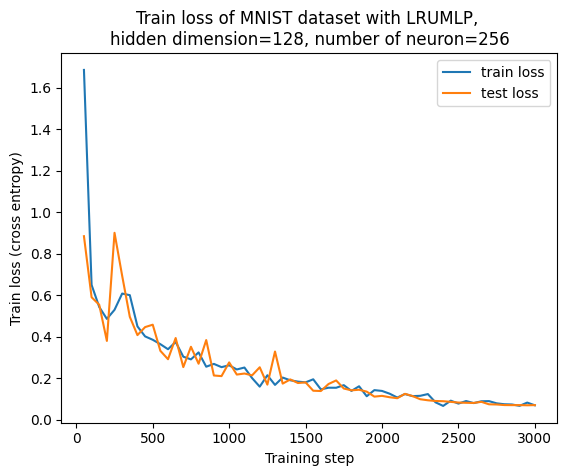

In [ ]:
# Plot the loss
import matplotlib.pyplot as plt

plt.plot(
    np.arange(eval_every, train_steps + eval_every, eval_every),
    metrics_history["train_loss"],
    label="train loss",
)
plt.plot(
    np.arange(eval_every, train_steps + eval_every, eval_every),
    metrics_history["test_loss"],
    label="test loss",
)
plt.title(
    "Train loss of "
    + dataset_name
    + " dataset with "
    + method_name
    + ", \nhidden dimension="
    + str(hidden_size)
    + ", number of neuron="
    + str(hidden_neuron)
)
plt.xlabel("Training step")
plt.ylabel("Train loss (cross entropy)")
plt.legend()
if leave_data:
    plt.savefig(
        "loss_"
        + method_name
        + "_"
        + str(encoded_size)
        + "_"
        + str(hidden_neuron)
        + "_"
        + dataset_name
        + "_step"
        + str(train_steps)
        + "r_min_"
        + str(r_min)
        + "r_max"
        + str(r_max)
        + ".jpg"
    )
plt.show()

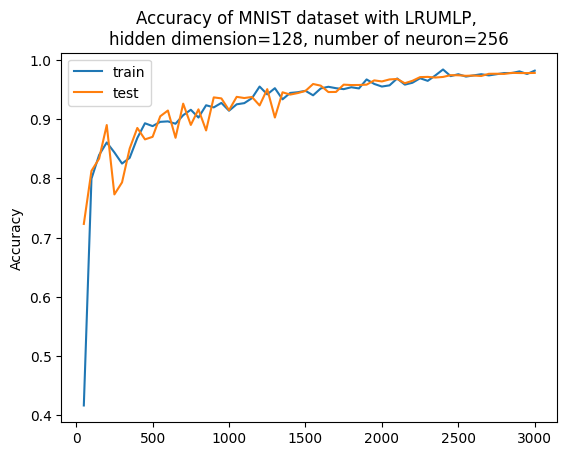

In [ ]:
# Plot the accuracy
plt.plot(
    np.arange(eval_every, train_steps + eval_every, eval_every),
    metrics_history["train_accuracy"],
    label="train",
)
plt.plot(
    np.arange(eval_every, train_steps + eval_every, eval_every),
    metrics_history["test_accuracy"],
    label="test",
)
plt.title(
    "Accuracy of "
    + dataset_name
    + " dataset with "
    + method_name
    + ", \nhidden dimension="
    + str(hidden_size)
    + ", number of neuron="
    + str(hidden_neuron)
)
plt.ylabel("Accuracy")
plt.legend()
if leave_data:
    plt.savefig(
        "accuracy_"
        + method_name
        + "_"
        + str(encoded_size)
        + "_"
        + str(hidden_neuron)
        + "_"
        + dataset_name
        + "_step"
        + str(train_steps)
        + "r_min_"
        + str(r_min)
        + "r_max"
        + str(r_max)
        + ".jpg"
    )
plt.show()